In [1]:
import bpy
import ipywidgets as widgets
from IPython.display import display

bpy.ops.wm.open_mainfile(filepath="dna.blend")

{'FINISHED'}

In [4]:
import anywidget
from traitlets import Unicode, Int, Tuple, observe, Bool, List, Any, Dict
from pathlib import Path
import pathlib
import base64

class TldrawSetImage(anywidget.AnyWidget):
    @staticmethod
    def base64_to_image_dimensions(base64_img_string):
        base64_img_string_only = base64_img_string.split(",")[1]
        decoded_bytes = base64.b64decode(base64_img_string_only)
        if decoded_bytes[:8] != b"\x89PNG\r\n\x1a\n":
            raise ValueError("Invalid PNG file")
        ihdr_start = 8
        ihdr_end = decoded_bytes.find(b"IHDR") + 4 + 8
        ihdr_chunk = decoded_bytes[ihdr_start:ihdr_end]
        image_width = int.from_bytes(ihdr_chunk[8:12], byteorder="big")
        image_height = int.from_bytes(ihdr_chunk[12:16], byteorder="big")
        return image_width, image_height

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def set_image(self, base64img):
        if not base64img:
            raise ValueError("No image provided")

        image_width, image_height = self.base64_to_image_dimensions(base64img)
        self.image_dimensions = (int(image_width / 2), int(image_height / 2))
        self.base64img = base64img

    base64img = Unicode("").tag(sync=True)
    image_dimensions = Tuple(Int(), Int(), default_value=(0, 0)).tag(sync=True)

    
    length = Int(100).tag(sync=True)
    coord = List().tag(sync=True)

    path_root = pathlib.Path().home()
    _esm = path_root / "projects/jupyter-tldraw/src/tldraw/static" / "image_set.js"
    _css = path_root / "projects/jupyter-tldraw/src/tldraw/static" / "image_set.css"

widget = TldrawSetImage()
widget

TldrawSetImage(image_dimensions=(0, 0))

Read blend: "/Users/jan-hendrik/projects/okapi/dna.blend"
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject/INSTANCE() via 'Collection Geometry'
  OBCurveObject/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject.001/INSTANCE() via 'Collection Geometry'
  OBCurveObject.001/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject.001/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject.002/INSTANCE() via 'Collection Geometry'
  OBCurveObject.002/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject.002/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifie

Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject/INSTANCE() via 'Collection Geometry'
  OBCurveObject/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject.001/INSTANCE() via 'Collection Geometry'
  OBCurveObject.001/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject.001/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject.002/INSTANCE() via 'Collection Geometry'
  OBCurveObject.002/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject.002/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_D

In [5]:


# Function to scale down the coordinates
def scale_down_points(points, scale_factor=0.01):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in points]
    return scaled_points

# Function to create the curve
def create_curve_from_points(points):
    # Create a new curve object
    curve_data = bpy.data.curves.new(name='Curve', type='CURVE')
    curve_data.dimensions = '3D'
    curve_data.fill_mode = 'FULL'
    
    # Create a new spline in that curve
    polyline = curve_data.splines.new('POLY')
    polyline.points.add(len(points) - 1)
    
    # Assign points to the spline
    for i, coord in enumerate(points):
        x, y = coord
        polyline.points[i].co = (x, y, 0, 1)  # Z-axis is set to 0, W to 1
    
    # Create an object with the curve data
    curve_obj = bpy.data.objects.new('CurveObject', curve_data)
    
    # Link the object to the main collection
    main_collection = bpy.context.scene.collection
    main_collection.objects.link(curve_obj)
    
    # Apply the Geometry Nodes modifier
    modifier = curve_obj.modifiers.new(name="GeometryNodes", type='NODES')
    modifier.node_group = bpy.data.node_groups["dna_node_setup"]
    
    return curve_obj

# Widget setup
output = widgets.Output()

def on_color_change(change):
    output.clear_output(wait=True)
    with output:
        # Extracting and scaling coordinates
        coord_data = change['new']  # assuming 'coord' is the observed property
        points = [(item['x'], -item['y']) for item in coord_data]
        
        # Scale down points by 0.01
        scaled_points = scale_down_points(points, 0.01)
        
        # Create the curve in Blender
        create_curve_from_points(scaled_points)
        
        # Display the scaled coordinates for verification
        print("Scaled Coordinates:", scaled_points)

        from IPython.display import Image, display, clear_output

        # Set render settings
        bpy.context.scene.render.resolution_x = 900
        bpy.context.scene.render.resolution_y = 900
        bpy.context.scene.render.image_settings.file_format = 'PNG'
        bpy.context.scene.render.image_settings.color_mode = 'RGBA'
        bpy.context.scene.render.film_transparent = True
        bpy.context.scene.render.engine = 'BLENDER_EEVEE_NEXT'
        bpy.context.scene.eevee.taa_render_samples = 16 
        # Render the scene
        bpy.ops.render.render()

        # Save the rendered image to a temporary path
        path = "test2.png"  # Use a temporary path
        bpy.data.images['Render Result'].save_render(filepath=path)

        # Display the rendered image in the notebook
        clear_output(wait=True)  # Clear the previous output
        display(Image(filename=path))
        from pathlib import Path
        import base64
        image_file_path = Path("test2.png")

        # Read the image into a base64 string
        with open(image_file_path, "rb") as image_file:
            base64_img_string = f"data:image/png;base64,{base64.b64encode(image_file.read()).decode('utf-8')}"
        widget.set_image(base64img = base64_img_string)


# Assuming the widget has been instantiated and the observed property is 'coord'
widget.observe(on_color_change, names='coord')

display(output)

Output()

Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject/INSTANCE() via 'Collection Geometry'
  OBCurveObject/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject.001/INSTANCE() via 'Collection Geometry'
  OBCurveObject.001/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject.001/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_DONE() depends on
  OBCurveObject.002/INSTANCE() via 'Collection Geometry'
  OBCurveObject.002/GEOMETRY_EVAL() via 'Transform -> Instance'
  OBCurveObject.002/MODIFIER(GeometryNodes) via 'modifier stack order'
  GRprim_DNA/GEOMETRY_EVAL_DONE() via 'Nodes Modifier'
Dependency cycle detected:
  GRprim_DNA/GEOMETRY_EVAL_D

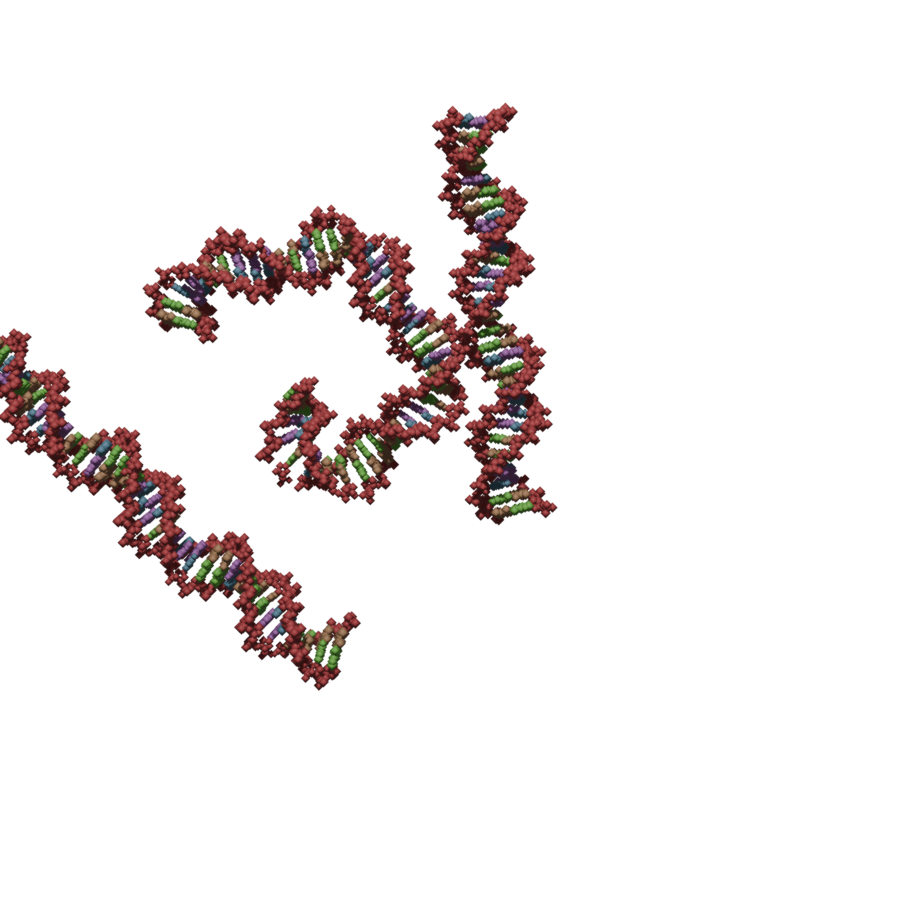

In [6]:
from IPython.display import Image, display, clear_output

# Set render settings
bpy.context.scene.render.resolution_x = 900
bpy.context.scene.render.resolution_y = 900
bpy.context.scene.render.image_settings.file_format = 'PNG'
bpy.context.scene.render.image_settings.color_mode = 'RGBA'
bpy.context.scene.render.film_transparent = True
bpy.context.scene.render.engine = 'BLENDER_EEVEE_NEXT'
bpy.context.scene.eevee.taa_render_samples = 16 
# Render the scene
bpy.ops.render.render()

# Save the rendered image to a temporary path
path = "test2.png"  # Use a temporary path
bpy.data.images['Render Result'].save_render(filepath=path)

# Display the rendered image in the notebook
clear_output(wait=True)  # Clear the previous output
display(Image(filename=path))